In [1]:
from builtins import zip
from builtins import str
from builtins import map
from builtins import range
from past.utils import old_div

import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import psutil
import scipy
from skimage.external.tifffile import TiffFile
import sys
import time
import logging

try:
    cv2.setNumThreads(0)
except:
    pass

try:
    if __IPYTHON__:
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.DEBUG)

import caiman as cm
from caiman.motion_correction import MotionCorrect, tile_and_correct, motion_correction_piecewise
from caiman.utils.utils import download_demo

       37573 [pyplot.py:      switch_backend():219] [7026] Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [60]:
%matplotlib notebook

      869119 [pyplot.py:      switch_backend():219] [7026] Loaded backend nbAgg version unknown.


In [13]:
import re
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]




In [55]:

def load_mc_results(results_dir, mc, prefix='Yr'):
    try:
        res = np.load(os.path.join(results_dir, '%s_mc-rigid.npz' % prefix), allow_pickle=True)
        #mc = mc_results[mc] 
        print(list(res.keys()))
        mc.fname = res['fname']
        mc.max_shifts = res['max_shifts']
        mc.min_mov = res['min_mov']
        mc.border_nan = res['border_nan']
        mc.fname_tot_rig = res['fname_tot_rig']
        mc.total_template_rig = res['total_template_rig']
        mc.templates_rig = res['templates_rig']
        mc.shifts_rig = res['shifts_rig']
        mc.mmap_file = res['mmap_file']
        mc.border_to_0 = res['border_to_0']
        mc.gSig_filt = res['gSig_filt']

    except Exception as e:
        print(e)
        print("Error loading MC")
        return None

    return mc 

# Select data

In [18]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC097'
session = '20190617'
fov = 'FOV1_zoom2p0x'
exp = 'blobs'


In [19]:
results_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, 'caiman_results', exp))[0]
os.listdir(results_dir)

['JC097-20190617-FOV1_zoom2p0x-blobs-Yr_mc-rigid.npz',
 'JC097-20190617-FOV1_zoom2p0x-blobs-Yr_memmap-params.json',
 'memmap']

In [20]:
glob.glob(os.path.join(results_dir, '*_mc-rigid.npz'))

['/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/caiman_results/blobs/JC097-20190617-FOV1_zoom2p0x-blobs-Yr_mc-rigid.npz']

#### Load MC

In [22]:
tmpfnames = sorted(glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, '%s_run*' % exp, 'raw_*', '*.tif')), key=natural_keys)
prefix = '-'.join([animalid, session, fov, exp, 'Yr'])
print(prefix)

JC097-20190617-FOV1_zoom2p0x-blobs-Yr


In [56]:
mc_fpath = glob.glob(os.path.join(results_dir, '*_mc-rigid.npz'))
assert len(mc_fpath)==1, "More than 1 MC found"
mc_fpath = mc_fpath[0]

In [57]:
# create a motion correction object
mc = MotionCorrect(tmpfnames)
#                  , dview=dview, max_shifts=max_shifts,
#                   strides=strides, overlaps=overlaps,
#                   max_deviation_rigid=max_deviation_rigid, 
#                   shifts_opencv=shifts_opencv, nonneg_movie=True,
#                   border_nan=border_nan)


In [58]:
mc = load_mc_results(results_dir, mc, prefix=prefix)


['fname', 'max_shifts', 'min_mov', 'border_nan', 'fname_tot_rig', 'total_template_rig', 'templates_rig', 'shifts_rig', 'mmap_file', 'border_to_0', 'gSig_filt']


# Set output dir

In [74]:
if not os.path.exists(os.path.join(results_dir, 'metrics')):
    os.makedirs(os.path.join(results_dir, 'metrics'))

# Evaluate

<IPython.core.display.Javascript object>


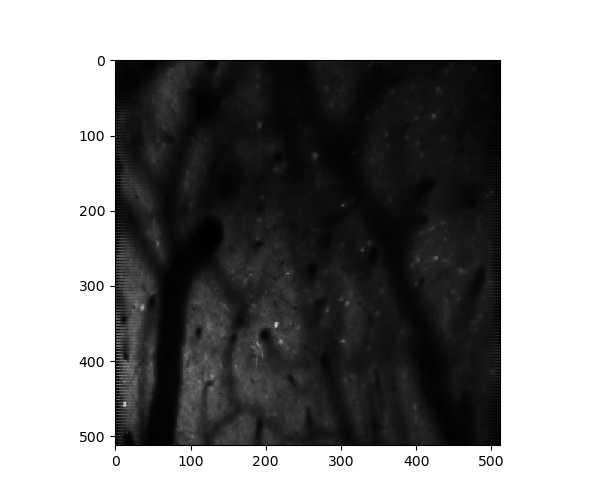

In [76]:
#%% visualize templates
plt.figure(figsize = (6,5))
plt.imshow(mc.total_template_rig, cmap = 'gray')
plt.savefig(os.path.join(results_dir, 'metrics', 'total_template_rig.png'))


<IPython.core.display.Javascript object>


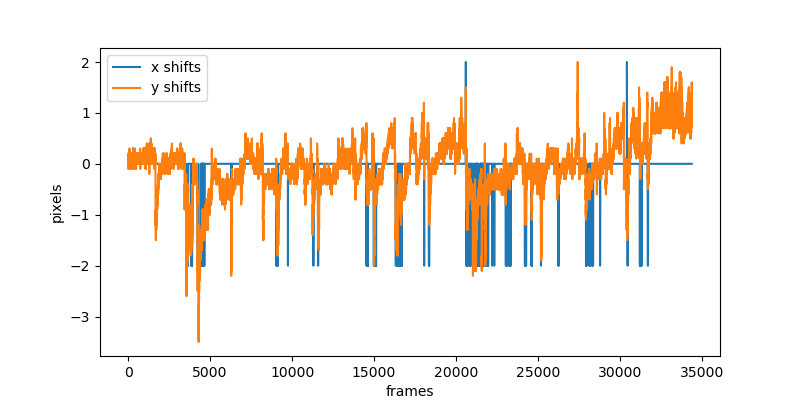

In [77]:
# plot the shifts computed by rigid registration
plt.figure(figsize = (8,4))
plt.plot(mc.shifts_rig)
plt.legend(['x shifts','y shifts'])
plt.xlabel('frames')
plt.ylabel('pixels')

plt.savefig(os.path.join(results_dir, 'metrics', 'shifts-rig.png'))


# Metrics

In [80]:
np.ceil(np.max(mc.shifts_rig)).astype(np.int)

2

In [65]:
#% compute metrics for the results (TAKES TIME!!)
bord_px_rig = np.ceil(np.max(mc.shifts_rig)).astype(np.int)

final_size = np.subtract(mc.total_template_rig.shape, 2 * bord_px_rig) # remove pixels in the boundaries
winsize = 100
swap_dim = False
resize_fact_flow = .2    # downsample for computing ROF


In [70]:
fnames = mc.fname
print(fnames[0])
tmpl_rig, correlations_orig, flows_orig, norms_orig, crispness_orig = cm.motion_correction.compute_metrics_motion_correction(
    fnames[0], final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)


tmpl_rig, correlations_rig, flows_rig, norms_rig, crispness_rig = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_rig[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)


/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/blobs_run1/raw_b4dcae/fov1_blobs_00001.tif


     1191350 [motion_correction.py:compute_metrics_motion_correction():2079] [7026] [2, -2, 2, -2]
     1192728 [motion_correction.py:compute_metrics_motion_correction():2086] [7026] Local correlations..
     1192729 [movies.py:  local_correlations():744] [7026] number of chunks:0 frames: [0, 1500]
     1199176 [movies.py:  local_correlations():752] [7026] number of chunks:1 frames: [1500, 3438]
     1207580 [motion_correction.py:compute_metrics_motion_correction():2088] [7026] (3438, 508, 508)
     1220775 [motion_correction.py:compute_metrics_motion_correction():2094] [7026] Compute Smoothness.. 
     1221935 [motion_correction.py:compute_metrics_motion_correction():2100] [7026] Compute correlations.. 
     1221936 [motion_correction.py:compute_metrics_motion_correction():2105] [7026] 0
     1222282 [motion_correction.py:compute_metrics_motion_correction():2105] [7026] 100
     1222617 [motion_correction.py:compute_metrics_motion_correction():2105] [7026] 200
     1222982 [motion_cor

     1469383 [motion_correction.py:compute_metrics_motion_correction():2105] [7026] 3200
     1469746 [motion_correction.py:compute_metrics_motion_correction():2105] [7026] 3300
     1470114 [motion_correction.py:compute_metrics_motion_correction():2105] [7026] 3400
     1470259 [motion_correction.py:compute_metrics_motion_correction():2111] [7026] Compute optical flow .. 
     1470260 [movies.py:              resize():853] [7026] reshaping along z
     1474507 [motion_correction.py:compute_metrics_motion_correction():2119] [7026] 0
     1491190 [motion_correction.py:compute_metrics_motion_correction():2119] [7026] 100
     1508003 [motion_correction.py:compute_metrics_motion_correction():2119] [7026] 200
     1524680 [motion_correction.py:compute_metrics_motion_correction():2119] [7026] 300
     1541938 [motion_correction.py:compute_metrics_motion_correction():2119] [7026] 400
     1558739 [motion_correction.py:compute_metrics_motion_correction():2119] [7026] 500
     1575704 [motion_

#### Plot correlation with mean frame for each dataset

<IPython.core.display.Javascript object>


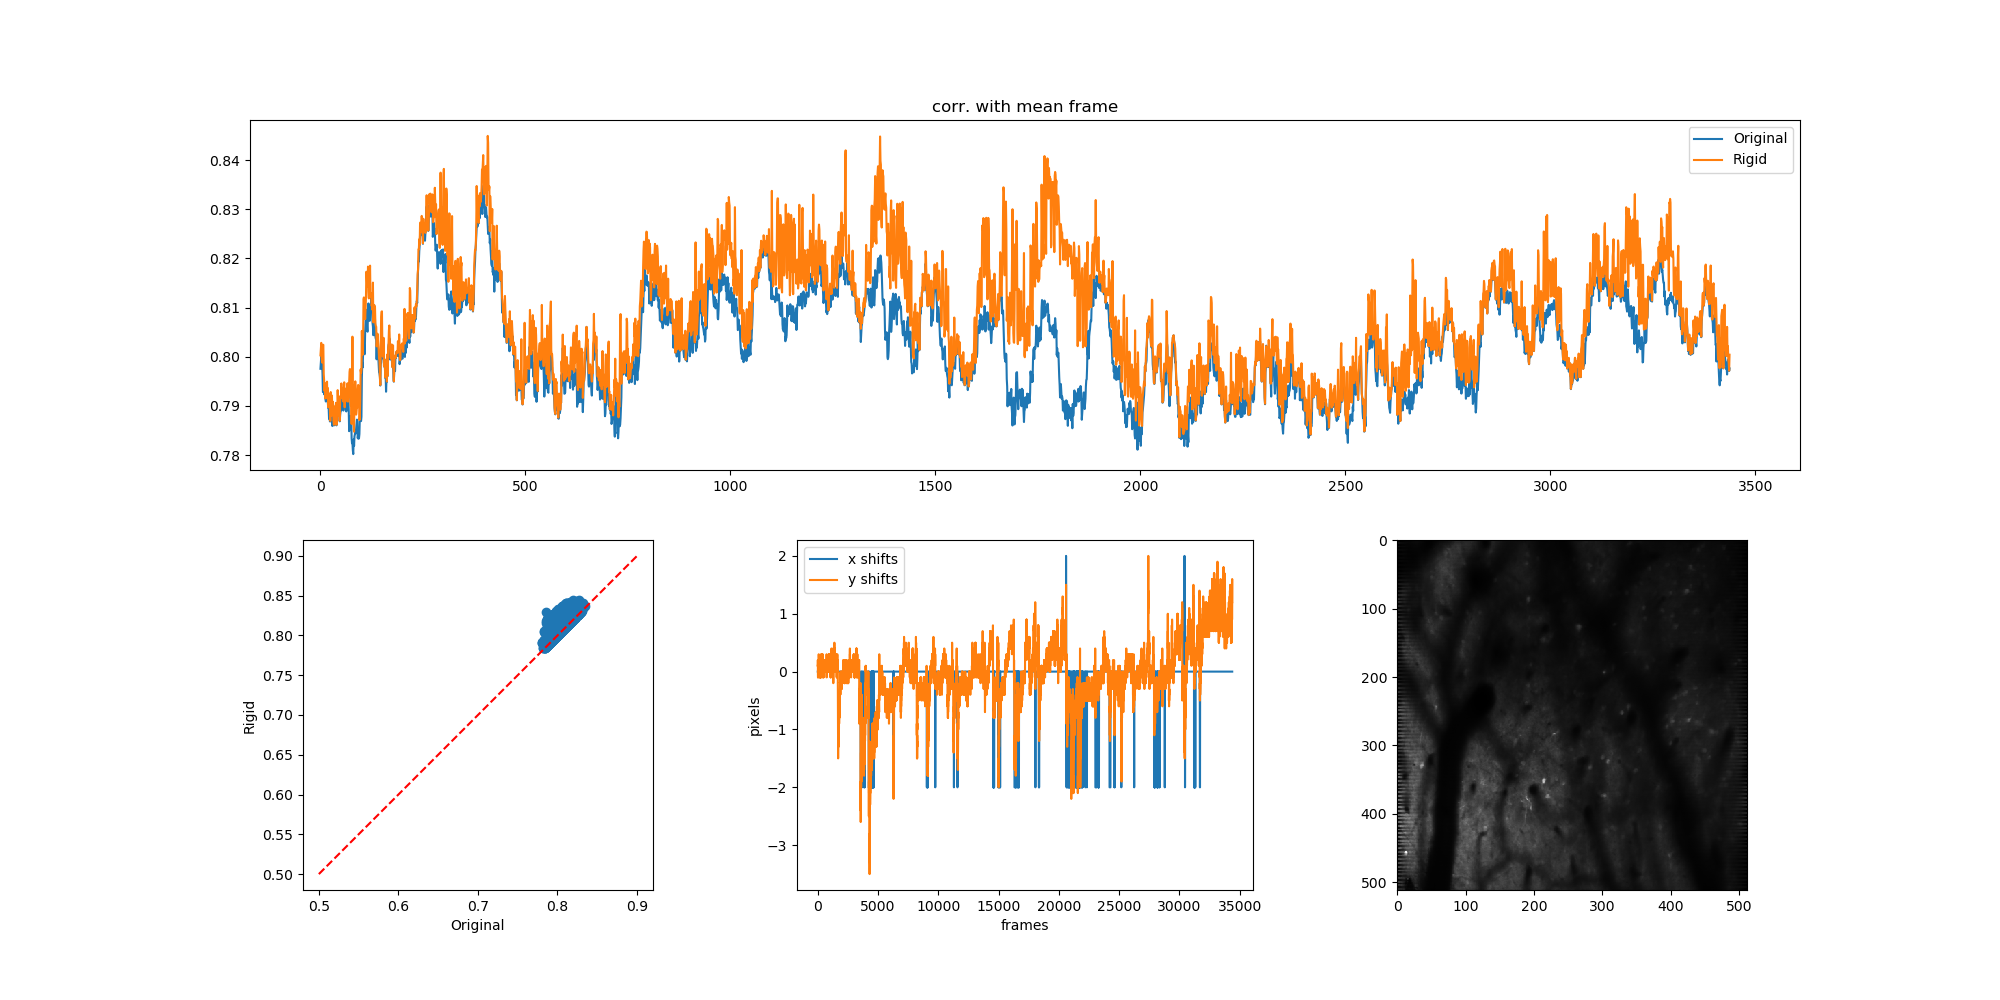

In [91]:
plt.figure(figsize = (20,10))
plt.subplot(211); plt.plot(correlations_orig); plt.plot(correlations_rig)
plt.legend(['Original','Rigid'])
plt.title('corr. with mean frame')

plt.subplot(234); plt.scatter(correlations_orig, correlations_rig); plt.xlabel('Original'); 
plt.ylabel('Rigid'); plt.plot([0.5,0.9],[0.5,0.9],'r--')
axes = plt.gca(); axes.set_xlim([0.5,0.9]); axes.set_ylim([0.5,0.9]); plt.axis('square');

plt.subplot(235); #plt.scatter(correlations_orig, correlations_rig); plt.xlabel('Original'); 
plt.plot(mc.shifts_rig)
plt.legend(['x shifts','y shifts'])
plt.xlabel('frames')
plt.ylabel('pixels')
#axes = plt.gca(); axes.set_xlim([0.5,0.9]); axes.set_ylim([0.5,0.9]); plt.axis('square');


plt.subplot(236); #plt.scatter(correlations_rig, correlations_els); plt.xlabel('Rigid'); 
#plt.ylabel('PW-Rigid'); plt.plot([0.3,0.7],[0.3,0.7],'r--')
#axes = plt.gca(); plt.axis('square');
plt.imshow(mc.total_template_rig, cmap='gray')

plt.savefig(os.path.join(results_dir, 'metrics', 'rig-summary.png'))


In [93]:
# print crispness values
print('Crispness original: '+ str(int(crispness_orig)))
print('Crispness rigid: '+ str(int(crispness_rig)))
#print('Crispness elastic: '+ str(int(crispness_els)))

Crispness original: 39314
Crispness rigid: 40169


<IPython.core.display.Javascript object>


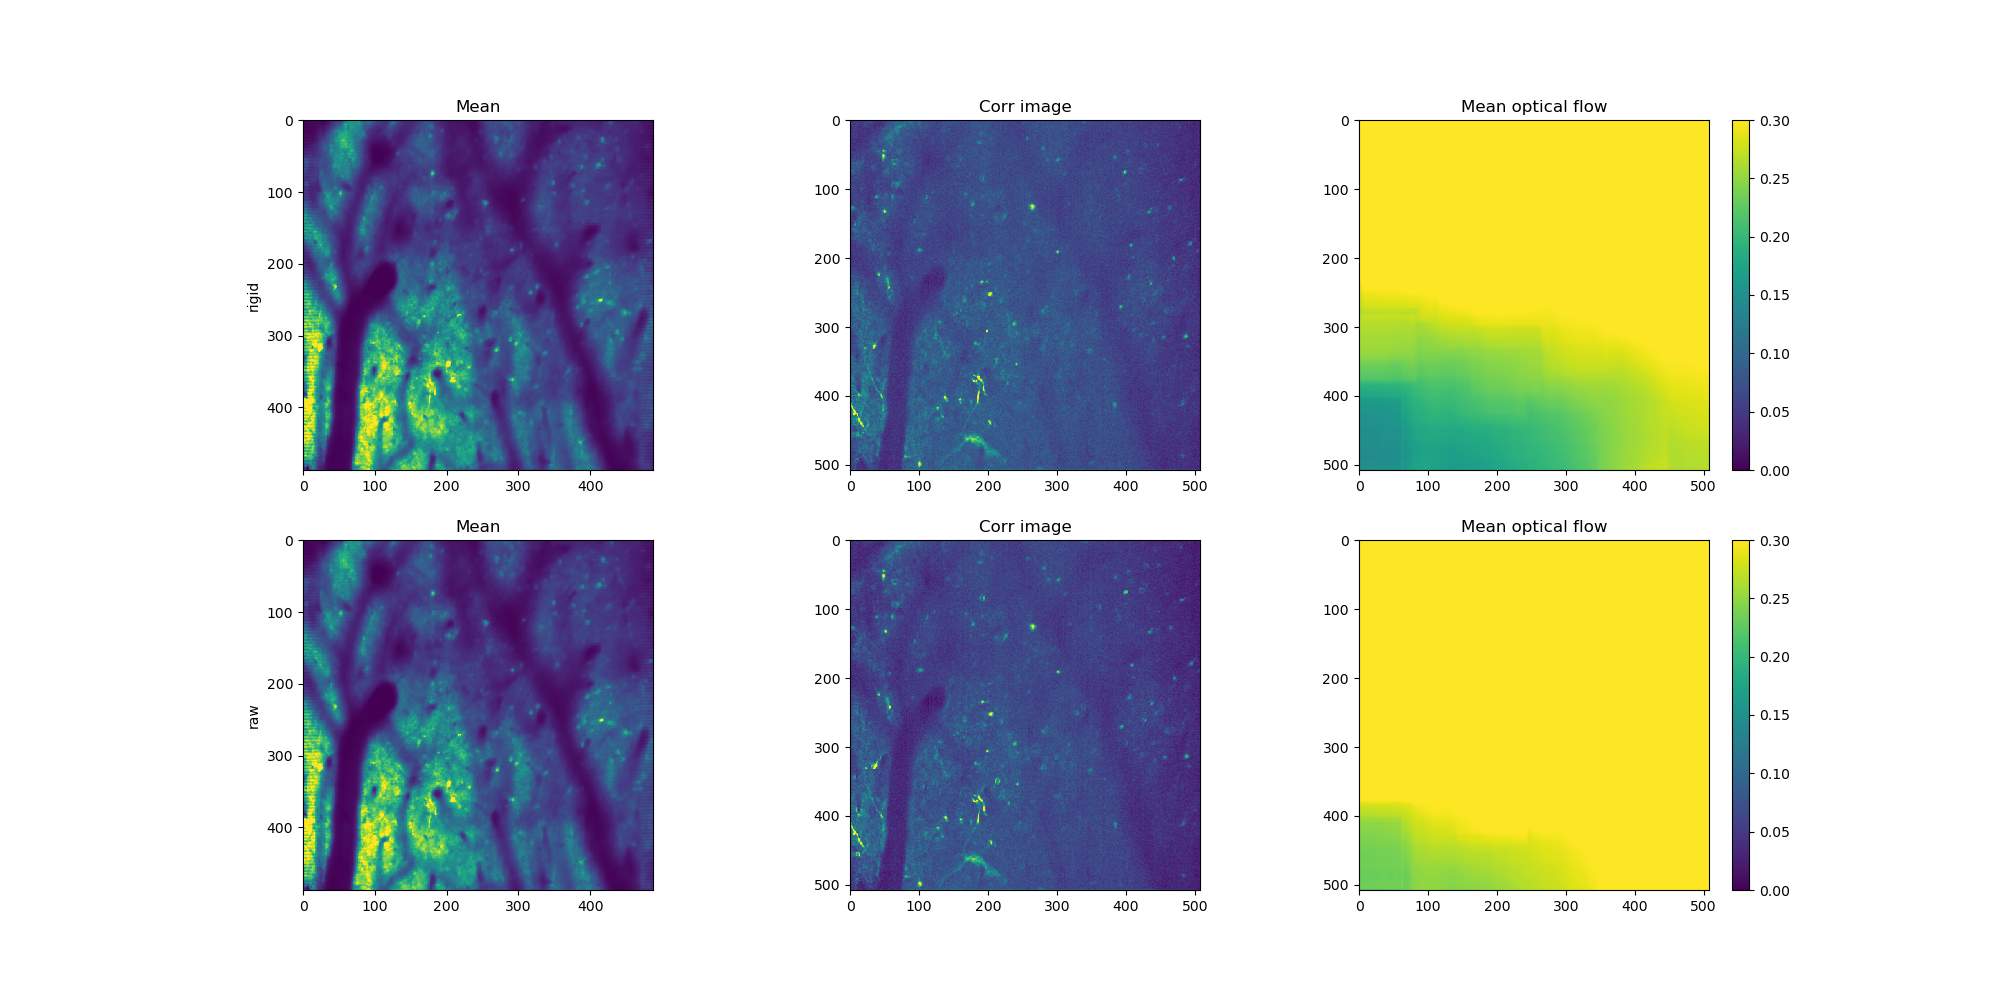

     2703754 [movies.py:                load():1363] [7026] mmap


KeysView(<numpy.lib.npyio.NpzFile object at 0x7f680950f128>)
/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/blobs_run1/raw_b4dcae/fov1_blobs_00001_rig__d1_512_d2_512_d3_1_order_F_frames_3438_._metrics.npz
169.96484+/-85.040504 ; 40169.312 ; 6.573118831963939


     2768016 [colorbar.py:_get_ticker_locator_formatter():560] [7026] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f68271e2d68>
     2768017 [colorbar.py:        update_ticks():608] [7026] Using auto colorbar locator on colorbar
     2768017 [colorbar.py:        update_ticks():609] [7026] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f68271e2d68>
     2768018 [colorbar.py:         _add_solids():780] [7026] Setting pcolormesh
     2768194 [movies.py:                load():1394] [7026] File request:[/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/blobs_run1/raw_b4dcae/fov1_blobs_00001mmap] not found!


KeysView(<numpy.lib.npyio.NpzFile object at 0x7f680958b860>)
/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/blobs_run1/raw_b4dcae/fov1_blobs_00001_metrics.npz
208.91144+/-153.06831 ; 39314.13 ; 6.5966079559068564


     2842395 [colorbar.py:_get_ticker_locator_formatter():560] [7026] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f6809e0ee80>
     2842395 [colorbar.py:        update_ticks():608] [7026] Using auto colorbar locator on colorbar
     2842396 [colorbar.py:        update_ticks():609] [7026] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f6809e0ee80>
     2842396 [colorbar.py:         _add_solids():780] [7026] Setting pcolormesh


In [96]:
#%% plot the results of Residual Optical Flow
fls = [mc.fname_tot_rig[0][:-4] + '_metrics.npz', mc.fname[0][:-4] + '_metrics.npz']

plt.figure(figsize = (20,10))
for cnt, fl, metr in zip(range(len(fls)), fls, ['rigid','raw']):
    with np.load(fl) as ld:
        print(ld.keys())
        print(fl)
        print(str(np.mean(ld['norms'])) + '+/-' + str(np.std(ld['norms'])) +
              ' ; ' + str(ld['smoothness']) + ' ; ' + str(ld['smoothness_corr']))
        
        plt.subplot(len(fls), 3, 1 + 3 * cnt)
        plt.ylabel(metr)
        try:
            mean_img = np.mean(
            cm.load(fl[:-12] + 'mmap'), 0)[12:-12, 12:-12]
        except:
            try:
                mean_img = np.mean(
                    cm.load(fl[:-12] + '.tif'), 0)[12:-12, 12:-12]
            except:
                mean_img = np.mean(
                    cm.load(fl[:-12] + 'hdf5'), 0)[12:-12, 12:-12]
                    
        lq, hq = np.nanpercentile(mean_img, [.5, 99.5])
        plt.imshow(mean_img, vmin=lq, vmax=hq)
        plt.title('Mean')
        plt.subplot(len(fls), 3, 3 * cnt + 2)
        plt.imshow(ld['img_corr'], vmin=0, vmax=.35)
        plt.title('Corr image')
        plt.subplot(len(fls), 3, 3 * cnt + 3)
        #plt.plot(ld['norms'])
        #plt.xlabel('frame')
        #plt.ylabel('norm opt flow')
        #plt.subplot(len(fls), 3, 3 * cnt + 3)
        flows = ld['flows']
        plt.imshow(np.mean(
        np.sqrt(flows[:, :, :, 0]**2 + flows[:, :, :, 1]**2), 0), vmin=0, vmax=0.3)
        plt.colorbar()
        plt.title('Mean optical flow')
        
plt.savefig(os.path.join(results_dir, 'metrics', 'optical-flow.png'))


In [100]:
mc.fname_tot_rig

array(['/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/blobs_run1/raw_b4dcae/fov1_blobs_00001_rig__d1_512_d2_512_d3_1_order_F_frames_3438_.mmap',
       '/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/blobs_run1/raw_b4dcae/fov1_blobs_00002_rig__d1_512_d2_512_d3_1_order_F_frames_3438_.mmap',
       '/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/blobs_run1/raw_b4dcae/fov1_blobs_00003_rig__d1_512_d2_512_d3_1_order_F_frames_3438_.mmap',
       '/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/blobs_run1/raw_b4dcae/fov1_blobs_00004_rig__d1_512_d2_512_d3_1_order_F_frames_3438_.mmap',
       '/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/blobs_run1/raw_b4dcae/fov1_blobs_00005_rig__d1_512_d2_512_d3_1_order_F_frames_3438_.mmap',
       '/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/blobs_run1/raw_b4dcae/fov1_blobs_00006_rig__d1_512_d2_512_d3_1_order_F_frames_3438_.mmap',
       '/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/blobs_run1/raw_b4dcae/fov1_blobs_00007_rig__d1_512_d2_512_d3_1

In [101]:
m_rig = cm.load(mc.mmap_file[0])


     2924775 [movies.py:                load():1363] [7026] mmap


In [105]:
m_orig = cm.load_movie_chain([fnames[0]])


100%|██████████| 1/1 [01:32<00:00, 92.26s/it]


In [106]:
m_orig.shape

(3438, 512, 512)

In [110]:
downsample_ratio=0.1

In [112]:
print(mc.nonneg_movie)
print(mc.min_mov)
print(downsample_ratio)
print(bord_px_rig)

True
-503.0
0.1
2


In [ ]:
downsample_ratio=0.1

In [117]:
fr=60
mag=2

movie_name = os.path.join(results_dir, 'metrics', 'sample-movie_ds-%.1f_fr%i_mag%i.tif' % (downsample_ratio, fr, mag))
print(movie_name)

/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/caiman_results/blobs/metrics/sample-movie_ds-0.1_fr60_mag2.tif


In [116]:
cm.concatenate([m_orig.resize(1, 1, downsample_ratio) - mc.min_mov*mc.nonneg_movie,
                m_rig.resize(1, 1, downsample_ratio)], axis=2).play(fr=60, q_max=99.5, 
                                                                    magnification=2, bord_px=bord_px_rig,
                                                                  movie_name=movie_name)

     3782311 [movies.py:              resize():853] [7026] reshaping along z
     3783817 [movies.py:              resize():853] [7026] reshaping along z


TypeError: play() got an unexpected keyword argument 'save'

In [ ]:
cm.concatenate([m_orig.resize(1, 1, downsample_ratio) - mc.min_mov*mc.nonneg_movie,
                m_rig.resize(1, 1, downsample_ratio)], axis=2).save(
movie_name)

     4019984 [movies.py:              resize():853] [7026] reshaping along z
     4021511 [movies.py:              resize():853] [7026] reshaping along z
